## Here we improve the program given in https://becominghuman.ai/neural-networks-for-solving-differential-equations-fa230ac5e04c . We boost the speed x30

## DE

Here we solve one of the most trivial ODEs:

$$\frac{dy}{dx} = y$$

with IC: $(0,1)$. The analytic solution to this ODE is $y = e^x$.

In [3]:
# import numpy as np
import autograd.numpy as np
from autograd import grad 
import autograd.numpy.random as npr

from autograd.core import primitive

from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
def A(x):
    '''
        Left part of initial equation
    '''
    return 1
    #return x + (1. + 3.*x**2) / (1. + x + x**3)


def B(x):
    '''
        Right part of initial equation
    '''
    return 0
    #return x**3 + 2.*x + x**2 * ((1. + 3.*x**2) / (1. + x + x**3))


def f(x, psy):
    '''
        d(psy)/dx = f(x, psy)
        This is f() function on the right
    '''
    return psy
    #return B(x) - psy * A(x)


def psy_analytic(x):
    '''
        Analytical solution of current problem
    '''
    return np.exp(x)
    #return (np.exp((-x**2)/2.)) / (1. + x + x**3) + x**2

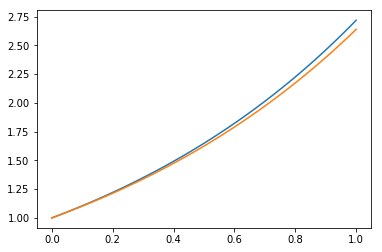

In [5]:
# Blue line is analytic
# Orange line is Euler method solution

nx = 50
dx = 1. / nx

x_space = np.linspace(0, 1, nx)    
y_space = psy_analytic(x_space)
psy_fd = np.zeros_like(y_space)
psy_fd[0] = 1. # IC

for i in range(1, len(x_space)):
    psy_fd[i] = psy_fd[i-1] + B(x_space[i]) * dx + psy_fd[i-1] * A(x_space[i]) * dx
  
plt.figure()
plt.plot(x_space, y_space) 
plt.plot(x_space, psy_fd)
plt.show()

In [62]:
## NN Architecture

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def neural_network(W, x):
    a1 = sigmoid(np.dot(x, W[0]))
    return np.dot(a1, W[1])

def d_neural_network_dx(W, x, k=1):
    return np.dot(np.dot(W[1].T, W[0].T**k), sigmoid_grad(x))

def loss_function(W, x):
    loss_sum = 0.
    for xi in x:
        net_out = neural_network(W, xi)[0][0]
        psy_t = 1. + xi * net_out
        d_net_out = d_neural_network_dx(W, xi)[0][0]
        d_psy_t = net_out + xi * d_net_out
        func = f(xi, psy_t)       
        err_sqr = (d_psy_t - func)**2
#         print(err_sqr)

        loss_sum += err_sqr
    return loss_sum

In [57]:
Z = np.dot(W[1].T, W[0].T**1)*sigmoid_grad(x_space)
Z.flatten()

array([0.97620475, 0.97610311, 0.97579828, 0.97529051, 0.97458023,
       0.97366802, 0.97255463, 0.97124101, 0.96972822, 0.96801753,
       0.96611033, 0.9640082 , 0.96171286, 0.95922617, 0.95655016,
       0.953687  , 0.95063899, 0.94740857, 0.94399834, 0.94041098,
       0.93664934, 0.93271637, 0.92861513, 0.9243488 , 0.91992066,
       0.91533409, 0.91059257, 0.90569967, 0.90065903, 0.89547438,
       0.89014953, 0.88468833, 0.87909471, 0.87337267, 0.86752622,
       0.86155946, 0.8554765 , 0.84928148, 0.84297859, 0.83657203,
       0.83006601, 0.82346477, 0.81677253, 0.80999354, 0.80313203,
       0.79619223, 0.78917834, 0.78209457, 0.77494508, 0.76773401])

In [8]:
W = [npr.randn(1, 10), npr.randn(10, 1)]
lmb = 0.001

In [15]:
np.shape(np.array([1, 2, 3]))

(3,)

In [59]:
def vectorised_d_neural_network(W,x, k=1):
    vectorised_a1 = sigmoid(np.matmul(W[0].T, np.reshape(x_space, (1,len(x_space)))))
    return np.matmul( vectorised_a1.T, W[1]).flatten()

def vectorised_d_neural_network_dx(W, x, k=1):
    Z = np.dot(W[1].T, W[0].T**k)*sigmoid_grad(x)
    return Z.flatten()

### Here is our vectorised version

In [1]:
def loss_function2(W, x):
    '''loss_sum = 0.
    for xi in x:
        net_out = neural_network(W, xi)[0][0]
        psy_t = 1. + xi * net_out
        d_net_out = d_neural_network_dx(W, xi)[0][0]
        d_psy_t = net_out + xi * d_net_out
        func = f(xi, psy_t)       
        err_sqr = (d_psy_t - func)**2
#         print(err_sqr)

        loss_sum += err_sqr
    return loss_sum'''
    vec_net_out = vectorised_neural_network(W,x)
    vec_psy_t = 1. + x * vec_net_out
    vec_d_net_out = vectorised_d_neural_network_dx(W, x)
    vec_d_psy_t = vec_net_out + x * vec_d_net_out
    func = f(x, vec_psy_t)       
    err_sqr = np.sum((vec_d_psy_t - func)**2)
    return err_sqr

In [65]:
%%timeit
loss_function(W,x_space)

1.07 ms ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [68]:
%%time
loss_function2(W,x_space)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 576 µs


0.4703427837783457

In [69]:
%%time
for i in range(1000):
    loss_grad =  grad(loss_function)(W, x_space)
    
#     print loss_grad[0].shape, W[0].shape
#     print loss_grad[1].shape, W[1].shape
    
    W[0] = W[0] - lmb * loss_grad[0]
    W[1] = W[1] - lmb * loss_grad[1]
    
#     print loss_function(W, x_space)

CPU times: user 47.4 s, sys: 584 ms, total: 48 s
Wall time: 46.7 s


In [70]:
%%time
for i in range(1000):
    loss_grad =  grad(loss_function2)(W, x_space)
    
#     print loss_grad[0].shape, W[0].shape
#     print loss_grad[1].shape, W[1].shape
    
    W[0] = W[0] - lmb * loss_grad[0]
    W[1] = W[1] - lmb * loss_grad[1]
    
#     print loss_function(W, x_space)

CPU times: user 1.29 s, sys: 40 ms, total: 1.33 s
Wall time: 1.28 s


0.4697629092338828
[array([[ 1.90404522, -0.23499739,  0.66143839,  1.98577858,  0.27925992,
         1.16316955,  1.40180524, -0.27228402, -0.42921001, -0.94120553]]), array([[ 0.77351779],
       [-0.57165397],
       [ 0.45686897],
       [ 0.35851765],
       [-1.31887797],
       [ 0.4069638 ],
       [ 1.020305  ],
       [ 0.53417198],
       [-0.24753684],
       [ 0.22358681]])]


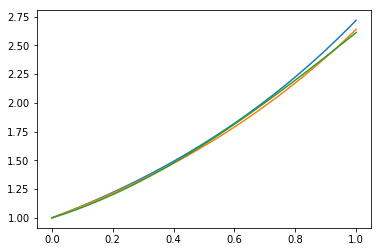

In [71]:
print (loss_function(W, x_space))
res = [1 + xi * neural_network(W, xi)[0][0] for xi in x_space] 

print (W)

plt.figure()
plt.plot(x_space, y_space) 
plt.plot(x_space, psy_fd)
plt.plot(x_space, res)
plt.show()